# <b> Personality Prediction using Machine Learning
### (Logistic Regression, SVC, Naive Bayes, Random Forest)
### A person’s personality can be classified based on the 16 classes of Myers-Briggs personality types across 4 charcteristics traits. 
- ### Introversion (I) - Extroversion (E)
- ### Intuition (N) - Sensing (S)
- ### Thinking (T) - Feeling (F)
- ### Judging (J) - Perceiving (P)
___
### This notebook is divided into four sections,
- ### Section 1: Data Preprocessing
- ### Section 2: Training Model
- ### Section 3: Testing Model
- ### Section 4: Final Model (For Web App)

# Section 1: Data Pre-processing

In [ ]:
# Data Processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Text cleaning
import re
import nltk

nltk.download("stopwords")
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Retrieve dataset stored in GDrive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# mbti (Myers Briggs Personality Types) dataset - https://www.kaggle.com/datasnaek/mbti-type
data = pd.read_csv("/content/drive/MyDrive/personality_data/mbti_1.csv")
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
data.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,"'Dear ENFJ, I can't relate to wishy-washy. Y..."
freq,1832,1


In [ ]:
data.shape

(8675, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [ ]:
# checking for missing values
data.isnull().sum()

type     0
posts    0
dtype: int64

In [ ]:
print("Count of each class in dataset\n",data["type"].value_counts())

Count of each class in dataset
 INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


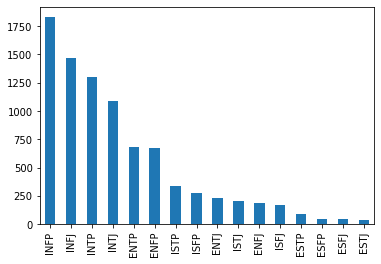

In [ ]:
# visually showing the class imbalance
data["type"].value_counts().plot(kind="bar")
plt.show()

In [ ]:
# to handle the class imbalance, we are converting the 16 classes into 4 more balanced classes

data["Extroversion"] = data["type"].apply(lambda x: 1 if x[0] == "E" else 0)
data["Sensing"] = data["type"].apply(lambda x: 1 if x[1] == "S" else 0)
data["Thinking"] = data["type"].apply(lambda x: 1 if x[2] == "T" else 0)
data["Judging"] = data["type"].apply(lambda x: 1 if x[3] == "J" else 0)

data.head()

,type,posts,Extroversion,Sensing,Thinking,Judging
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,1


In [ ]:
# checking individual counts
introvert_count, extrovert_count = data["Extroversion"].value_counts()
intuition_count, sensing_count = data["Sensing"].value_counts()
feeling_count, thinking_count = data["Thinking"].value_counts()
perceiving_count, judging_count = data["Judging"].value_counts()

print(f"Introvert Count: {introvert_count}")
print(f"Extrovert Count: {extrovert_count}")
print(f"Intuition Count: {intuition_count}")
print(f"Sensing Count: {sensing_count}")
print(f"Feeling Count: {feeling_count}")
print(f"Thinking Count: {thinking_count}")
print(f"Perceiving Count: {perceiving_count}")
print(f"Judging Count: {judging_count}")

Introvert Count: 6676
Extrovert Count: 1999
Intuition Count: 7478
Sensing Count: 1197
Feeling Count: 4694
Thinking Count: 3981
Perceiving Count: 5241
Judging Count: 3434


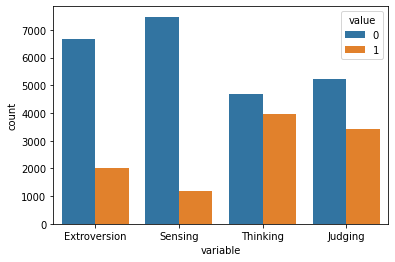

In [ ]:
sns.countplot(x="variable", hue="value", data = pd.melt(data[["Extroversion", "Sensing", "Thinking", "Judging"]]))
plt.show()

In [ ]:
corr = data[["Extroversion", "Sensing", "Thinking", "Judging"]].corr()
corr.style.background_gradient(cmap="Blues").set_precision(4)

,Extroversion,Sensing,Thinking,Judging
Extroversion,1.0000,-0.0459,0.0696,-0.1619
Sensing,-0.0459,1.0000,0.0810,-0.0149
Thinking,0.0696,0.0810,1.0000,-0.0047
Judging,-0.1619,-0.0149,-0.0047,1.0000


## 1.1 Cleaning data and Lemmatization

In [ ]:
# converting to lower case
data["clean_posts"] = data["posts"].str.lower()

# replacing ||| with space
data["clean_posts"] = data["clean_posts"].str.replace(re.compile(r"\|\|\|"), " ")

# dropping links
data["clean_posts"] = data["clean_posts"].str.replace(re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*"), "")

# dropping emails
data["clean_posts"] = data["clean_posts"].str.replace(re.compile(r"\S+@\S+"), "")

# dropping symbols
data["clean_posts"] = data["clean_posts"].str.replace(re.compile(r"[^a-z\s]"), " ")

# dropping MBTI types mentioned in the posts.
mbti = data["type"].unique()
for Ptype in mbti:
    data["clean_posts"] = data["clean_posts"].str.replace(Ptype.lower(), "")

In [ ]:
data.head()

,type,posts,Extroversion,Sensing,Thinking,Judging,clean_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,1,and moments sportscenter not top ten p...
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0,i m finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0,good one of course to which i say ...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1,dear i enjoyed our conversation the other...
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,1,you re fired that s another silly misconcept...


In [ ]:
# lemmatizing the posts

t = time.time()

lemmatizer = WordNetLemmatizer()

data["clean_posts"] = data["clean_posts"].apply(
    lambda x: " ".join(
        [
            lemmatizer.lemmatize(word)
            for word in x.split(" ")
            if word not in stopwords.words("english")
        ]
    )
)

print(f"Lemmatizing Time: {time.time() - t:.2f} seconds")

Lemmatizing Time: 1770.90 seconds


In [ ]:
# removing words of 1 or 2 length
data["clean_posts"] = data["clean_posts"].str.replace(re.compile(r"\b\w{1,2}\b"), "")

In [ ]:
# checking the cleaned and lemmitized data
data.head()

,type,posts,Extroversion,Sensing,Thinking,Judging,clean_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,1,moment sportscenter top ten play pr...
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0,finding lack post alarming sex boring positi...
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0,good one course say know blessing...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1,dear enjoyed conversation day esoteric ...
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,1,fired another silly misconception approachi...


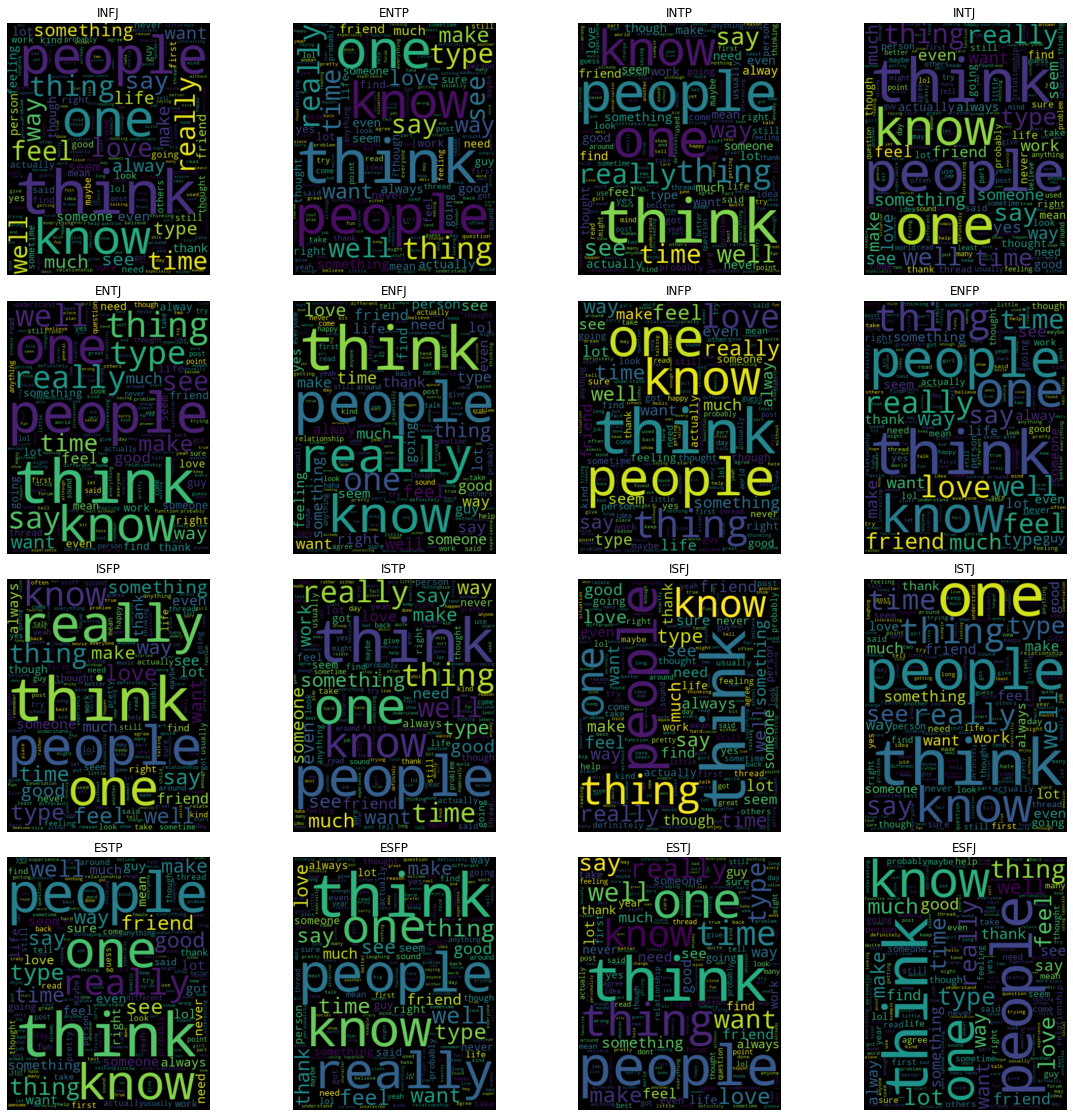

In [ ]:
# Generating a wordcloud for each class, just to visualize the words present in each class
from wordcloud import WordCloud

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = ax.ravel()

for i, mbti_type in enumerate(data["type"].unique()):
    wordcloud_words = " ".join(data[data["type"] == mbti_type]["clean_posts"])
    wordcloud = WordCloud(height=500).generate(wordcloud_words)
    ax[i].imshow(wordcloud, interpolation="bilinear")
    ax[i].axis("off")
    ax[i].set_title(mbti_type)

In [ ]:
# lemmatizing took long. So saving the clean and lemmitized file to save time in further processing.
data.to_csv("/content/drive/MyDrive/personality_data/clean_data_1.csv", index= False)

## 1.2 Sentiment Analysis

In [ ]:
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize

# sentiment scoring
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# scaling to handle negative values in sentiment scores (for Naive Bayes)
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# reading the cleaned dataset
data = pd.read_csv("/content/drive/MyDrive/personality_data/clean_data_1.csv")

In [ ]:
# sentiment scoring for each user
t = time.time()

analyzer = SentimentIntensityAnalyzer()

sentiment_score = []

for post in data["clean_posts"]:
    score = analyzer.polarity_scores(post)
    sentiment_score.append(score)

print(f"Sentiment Scoring Time: {time.time() - t:.2f} seconds")

Sentiment Scoring Time: 96.15 seconds


In [ ]:
# Sentiment scores have negative values that Naive Bayes can't handle. So scaling it.
min_max_scaler = MinMaxScaler()

data["compound_sentiment"] = min_max_scaler.fit_transform(np.array([score["compound"] for score in sentiment_score]).reshape(-1, 1))
data["positive_sentiment"] = min_max_scaler.fit_transform(np.array([score["pos"] for score in sentiment_score]).reshape(-1, 1))
data["negative_sentiment"] = min_max_scaler.fit_transform(np.array([score["neg"] for score in sentiment_score]).reshape(-1, 1))
data["neutral_sentiment"] = min_max_scaler.fit_transform(np.array([score["neu"] for score in sentiment_score]).reshape(-1, 1))

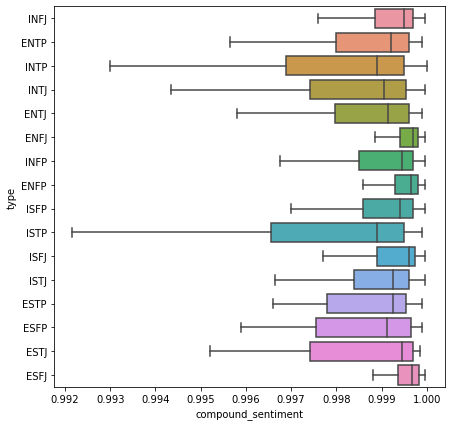

In [ ]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="compound_sentiment", data=data, showfliers=False)

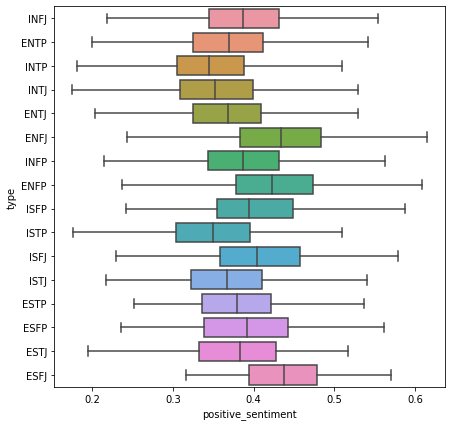

In [ ]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="positive_sentiment", data=data, showfliers=False)

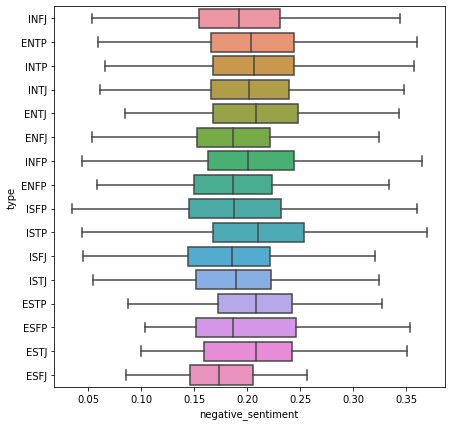

In [ ]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="negative_sentiment", data=data, showfliers=False)

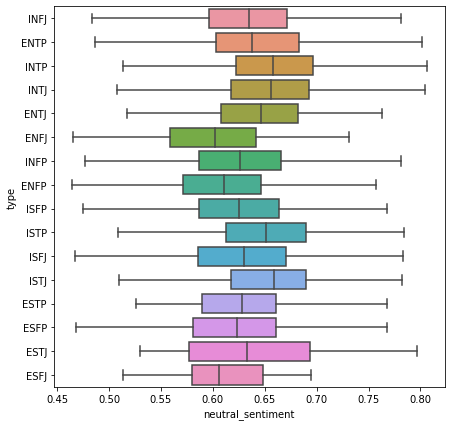

In [ ]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="neutral_sentiment", data=data, showfliers=False)

## 1.3 POS tagging

In [ ]:
# replacing urls with domain name
data["tag_posts"] = data["posts"].str.replace(re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*"), lambda match: match.group(2))

# replacing ||| with space
data["tag_posts"] = [post for post in data["tag_posts"].str.split("\|\|\|")]

In [ ]:
# parts of speech tagging for each word
t = time.time()

data["tagged_words"] = data["tag_posts"].apply(lambda x: [nltk.pos_tag(word_tokenize(line)) for line in x])

print(f"POS Tagging Time: {time.time() - t:.2f} seconds")

POS Tagging Time: 769.25 seconds


In [ ]:
# creating a list of POS tags
tag_set = set()

for i, dat in data["tagged_words"].iteritems():
    for pos in dat[0]:
        tag_set.add(pos[1])

tag_list = list(tag_set)
print(tag_list)

['SYM', 'NNPS', 'WP$', 'CC', 'NNP', '(', 'VBD', 'VB', 'DT', 'TO', 'RBR', 'EX', '$', 'POS', 'WDT', 'RBS', "''", 'MD', 'WP', 'PRP', 'VBN', 'JJ', ')', 'FW', 'VBZ', '.', 'CD', 'UH', ':', 'WRB', 'NN', 'NNS', ',', 'RP', 'PDT', 'IN', 'RB', 'LS', 'VBP', 'JJS', 'JJR', 'VBG', 'PRP$', '#']


In [ ]:
# calculating mean and standard deviation of pos tags for each user
t = time.time()

for tag in tag_list:
    data["POS_" + tag + "_mean"] = data["tagged_words"].apply(lambda x: np.mean([len([y for y in line if y[1] == tag]) for line in x]))
    data["POS_" + tag + "_std"] = data["tagged_words"].apply(lambda x: np.std([len([y for y in line if y[1] == tag]) for line in x]))

print(f"POS Stats Time: {time.time() - t:.2f} seconds")

POS Stats Time: 157.59 seconds


In [ ]:
# grouping pos tags based on stanford list
tags_dict = {
    "ADJ": ["JJ", "JJR", "JJS"],
    "ADP": ["EX", "TO"],
    "ADV": ["RB", "RBR", "RBS", "WRB"],
    "CONJ": ["CC", "IN"],
    "DET": ["DT", "PDT", "WDT"],
    "NOUN": ["NN", "NNS", "NNP", "NNPS"],
    "NUM": ["CD"],
    "PRT": ["RP"],
    "PRON": ["PRP", "PRP$", "WP", "WP$"],
    "VERB": ["MD", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"],
    ".": ["#", "$", "''", "(", ")", ",", ".", ":"],
    "X": ["FW", "LS", "UH"],
}

In [ ]:
# Stanford POS tag stats
t = time.time()

for tag in tags_dict.keys():
    data[tag + "_avg"] = data["tagged_words"].apply(lambda x: np.median([len([y for y in line if y[1] in tags_dict[tag]]) for line in x]))

print(f"Stanford POS Stats Time: {time.time() - t:.2f} seconds")

Stanford POS Stats Time: 37.70 seconds


In [ ]:
data.head(2)

,type,posts,Extroversion,Sensing,Thinking,Judging,clean_posts,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tag_posts,tagged_words,POS_SYM_mean,POS_SYM_std,POS_NNPS_mean,POS_NNPS_std,POS_WP$_mean,POS_WP$_std,POS_CC_mean,POS_CC_std,POS_NNP_mean,POS_NNP_std,POS_(_mean,POS_(_std,POS_VBD_mean,POS_VBD_std,POS_VB_mean,POS_VB_std,POS_DT_mean,POS_DT_std,POS_TO_mean,POS_TO_std,POS_RBR_mean,POS_RBR_std,POS_EX_mean,POS_EX_std,POS_$_mean,POS_$_std,POS_POS_mean,...,POS_NN_mean,POS_NN_std,POS_NNS_mean,POS_NNS_std,"POS_,_mean","POS_,_std",POS_RP_mean,POS_RP_std,POS_PDT_mean,POS_PDT_std,POS_IN_mean,POS_IN_std,POS_RB_mean,POS_RB_std,POS_LS_mean,POS_LS_std,POS_VBP_mean,POS_VBP_std,POS_JJS_mean,POS_JJS_std,POS_JJR_mean,POS_JJR_std,POS_VBG_mean,POS_VBG_std,POS_PRP$_mean,POS_PRP$_std,POS_#_mean,POS_#_std,ADJ_avg,ADP_avg,ADV_avg,CONJ_avg,DET_avg,NOUN_avg,NUM_avg,PRT_avg,PRON_avg,VERB_avg,._avg,X_avg
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,1,moment sportscenter top ten play pr...,0.996199,0.362667,0.206573,0.648148,['youtube and intj moments youtube sportscen...,"[[('youtube, NNS), (and, CC), (intj, JJ), (mom...",0.0,0.0,0.0,0.0,0.0,0.0,0.382353,0.594816,0.647059,1.025623,0.088235,0.373193,0.323529,0.794118,0.617647,1.283715,1.558824,1.958258,0.323529,0.628752,0.058824,0.235294,0.029412,0.168958,0.0,0.0,0.117647,...,3.558824,2.735294,1.029412,1.175367,0.470588,0.775936,0.058824,0.235294,0.088235,0.373193,2.294118,2.282019,1.176471,1.360592,0.0,0.0,0.558824,0.880881,0.088235,0.283637,0.029412,0.168958,0.411765,0.691020,0.470588,0.775936,0.0,0.0,1.0,0.0,1.0,2.0,1.0,4.0,0.0,0.0,1.0,2.0,2.5,0.0
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0,finding lack post alarming sex boring positi...,0.999350,0.392000,0.192488,0.635076,['I'm finding the lack of me in these posts ve...,"[[('I, POS), ('m, VBP), (finding, VBG), (the, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.911111,0.864670,1.911111,1.986870,0.066667,0.249444,0.622222,1.080923,1.333333,1.316561,2.044444,1.618718,0.666667,0.942809,0.022222,0.147406,0.044444,0.206080,0.0,0.0,0.111111,...,3.066667,2.112397,1.044444,1.010073,0.311111,0.626178,0.155556,0.362433,0.022222,0.147406,3.022222,1.983139,1.600000,1.511438,0.0,0.0,2.022222,1.914725,0.111111,0.314270,0.088889,0.284583,0.622222,0.708328,0.600000,0.711805,0.0,0.0,2.0,0.0,2.0,4.0,2.0,6.0,0.0,0.0,4.0,6.0,4.0,0.0


## 1.4 Counting

In [ ]:
def unique_words(s):
    unique = set(s.split(" "))
    return len(unique)

def emojis(post):
    emoji_count = len(re.findall(r'[\U0001f600-\U0001f650]', post))
    return emoji_count

def colons(post):
    colon_count = 0
    words = post.split()
    for e in words:
        if "http" not in e:
            colon_count += e.count(":")
    return colon_count

In [ ]:
data["qm"] = data["posts"].apply(lambda s: s.count("?"))
data["em"] = data["posts"].apply(lambda s: s.count("!"))
data["colons"] = data["posts"].apply(colons)
data["emojis"] = data["posts"].apply(emojis)

data["word_count"] = data["posts"].apply(lambda s: (s.count(" ") + 1))
data["unique_words"] = data["posts"].apply(unique_words)
data["post_length_var"] = data["posts"].apply(lambda x: np.var([len(post.split()) for post in x.split("|||")]))
data["upper"] = data["posts"].apply(lambda x: len([x for x in x.split() if x.isupper()]))

data["link_count"] = data["posts"].apply(lambda s: s.count("http"))
data["ellipses"] = [len(re.findall(r"\.\.\.\ ", posts)) for posts in data["posts"]]
data["img_count"] = [len(re.findall(r"(\.jpg)|(\.jpeg)|(\.gif)|(\.png)", post)) for post in data["posts"]]

In [ ]:
data.head(2)

,type,posts,Extroversion,Sensing,Thinking,Judging,clean_posts,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tag_posts,tagged_words,POS_SYM_mean,POS_SYM_std,POS_NNPS_mean,POS_NNPS_std,POS_WP$_mean,POS_WP$_std,POS_CC_mean,POS_CC_std,POS_NNP_mean,POS_NNP_std,POS_(_mean,POS_(_std,POS_VBD_mean,POS_VBD_std,POS_VB_mean,POS_VB_std,POS_DT_mean,POS_DT_std,POS_TO_mean,POS_TO_std,POS_RBR_mean,POS_RBR_std,POS_EX_mean,POS_EX_std,POS_$_mean,POS_$_std,POS_POS_mean,...,POS_IN_std,POS_RB_mean,POS_RB_std,POS_LS_mean,POS_LS_std,POS_VBP_mean,POS_VBP_std,POS_JJS_mean,POS_JJS_std,POS_JJR_mean,POS_JJR_std,POS_VBG_mean,POS_VBG_std,POS_PRP$_mean,POS_PRP$_std,POS_#_mean,POS_#_std,ADJ_avg,ADP_avg,ADV_avg,CONJ_avg,DET_avg,NOUN_avg,NUM_avg,PRT_avg,PRON_avg,VERB_avg,._avg,X_avg,qm,em,colons,emojis,word_count,unique_words,post_length_var,upper,link_count,ellipses,img_count
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,1,moment sportscenter top ten play pr...,0.996199,0.362667,0.206573,0.648148,['youtube and intj moments youtube sportscen...,"[[('youtube, NNS), (and, CC), (intj, JJ), (mom...",0.0,0.0,0.0,0.0,0.0,0.0,0.382353,0.594816,0.647059,1.025623,0.088235,0.373193,0.323529,0.794118,0.617647,1.283715,1.558824,1.958258,0.323529,0.628752,0.058824,0.235294,0.029412,0.168958,0.0,0.0,0.117647,...,2.282019,1.176471,1.360592,0.0,0.0,0.558824,0.880881,0.088235,0.283637,0.029412,0.168958,0.411765,0.691020,0.470588,0.775936,0.0,0.0,1.0,0.0,1.0,2.0,1.0,4.0,0.0,0.0,1.0,2.0,2.5,0.0,18,3,7,0,578,376,135.2900,13,24,7,7
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0,finding lack post alarming sex boring positi...,0.999350,0.392000,0.192488,0.635076,['I'm finding the lack of me in these posts ve...,"[[('I, POS), ('m, VBP), (finding, VBG), (the, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.911111,0.864670,1.911111,1.986870,0.066667,0.249444,0.622222,1.080923,1.333333,1.316561,2.044444,1.618718,0.666667,0.942809,0.022222,0.147406,0.044444,0.206080,0.0,0.0,0.111111,...,1.983139,1.600000,1.511438,0.0,0.0,2.022222,1.914725,0.111111,0.314270,0.088889,0.284583,0.622222,0.708328,0.600000,0.711805,0.0,0.0,2.0,0.0,2.0,4.0,2.0,6.0,0.0,0.0,4.0,6.0,4.0,0.0,5,0,18,0,1194,596,187.4756,82,10,0,8


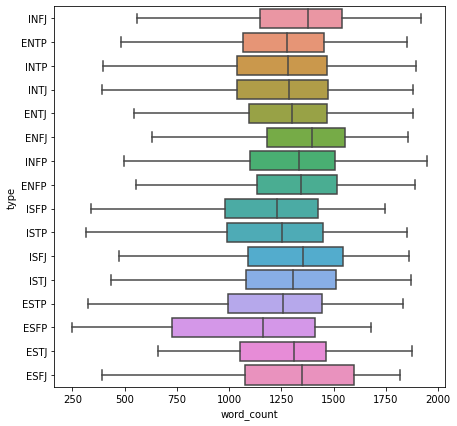

In [ ]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="word_count", data=data, showfliers=False)

## 1.5 Understanding Vectorization

In [ ]:
# vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Using TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=25, max_df=0.8)
tfidf_words = tfidf_vectorizer.fit_transform(data["clean_posts"])
tfidf_vectorized_data = pd.DataFrame(data=tfidf_words.toarray(), columns=tfidf_vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
tfidf_vectorized_data.head()

,aback,abandon,abandoned,abandoning,abandonment,abbey,abbreviation,abhor,abide,ability,abit,able,abnormal,aboard,abortion,abrasive,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absorb,absorbed,absorbing,abstract,abstraction,absurd,absurdity,abundance,abuse,abused,abuser,abusing,abusive,abyss,academia,academic,academically,...,yearn,yearning,yeh,yell,yelled,yelling,yellow,yep,yes,yesterday,yet,yield,yikes,yin,yoda,yoga,yogurt,yolo,york,young,younger,youngest,youre,youth,youtube,youx,yum,yummy,yup,zealand,zelda,zen,zero,zodiac,zombie,zone,zoned,zoning,zoo,zoom
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0492,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.063402,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.024603,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.077013,0.0,0.027923,0.0,0.0,0.0,0.0,0.0,0.090006,0.0,0.0,0.0,0.000000,0.0672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.037956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.053126,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.049317,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.037220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Using CountVectorizer

count_vectorizer = CountVectorizer(decode_error="ignore", min_df=25, max_df=0.8)
count_words = count_vectorizer.fit_transform(data["clean_posts"])
count_vectorized_data = pd.DataFrame(data=count_words.toarray(), columns=count_vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
count_vectorized_data.head()

,aback,abandon,abandoned,abandoning,abandonment,abbey,abbreviation,abhor,abide,ability,abit,able,abnormal,aboard,abortion,abrasive,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absorb,absorbed,absorbing,abstract,abstraction,absurd,absurdity,abundance,abuse,abused,abuser,abusing,abusive,abyss,academia,academic,academically,...,yearn,yearning,yeh,yell,yelled,yelling,yellow,yep,yes,yesterday,yet,yield,yikes,yin,yoda,yoga,yogurt,yolo,york,young,younger,youngest,youre,youth,youtube,youx,yum,yummy,yup,zealand,zelda,zen,zero,zodiac,zombie,zone,zoned,zoning,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.to_csv("/content/drive/MyDrive/personality_data/clean_data_2.csv", index= False)

# Section 2: Training Model

In [ ]:
# data splitting
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer

# class imbalance
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler

# algorithms/models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import roc_auc_score, accuracy_score

import time
import warnings
warnings.filterwarnings("ignore")

# saving the model
from joblib import load, dump

In [ ]:
# preprocessing steps for selecting best k columns/features from counts & scores and for vectorizing words

counts_n_scores = [
    "compound_sentiment",
    "ADJ_avg",
    "ADP_avg",
    "ADV_avg",
    "CONJ_avg",
    "DET_avg",
    "NOUN_avg",
    "NUM_avg",
    "PRT_avg",
    "PRON_avg",
    "VERB_avg",
    "qm",
    "em",
    "colons",
    "emojis",
    "word_count",
    "unique_words",
    "upper",
    "link_count",
    "ellipses",
    "img_count",
]

# for selecting k best features from features other than words
best_k_features = make_pipeline(MinMaxScaler(), SelectKBest(f_classif))

# setting up preprocessing for TF-IDF vectorizer
preprocesser_tf = ColumnTransformer(
    transformers=[
        (
            "tfidf", TfidfVectorizer(min_df=10, max_df=0.90), "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

# setting up preprocessing for COUNT vectorizer
preprocesser_ct = ColumnTransformer(
    transformers=[
        (
            "ct_vect", CountVectorizer(min_df=10, max_df=0.90), "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

In [ ]:
# setting up the personality dictionary for printing scores for each class
mbti_type = {
    "Extroversion": "Extrovert vs Introvert",
    "Sensing": "Sensing vs Intuition",
    "Thinking": "Thinking vs Feeling",
    "Judging": "Judging vs Perceiving",
}

# function to build the model for predicting each of the 4 target classes
def build_model(model, X, y, vectorizer_name):

    t = time.time()

    for col in y.columns:

        print(f"\n{mbti_type[col]}")
        target = y[col]

        # splitting data into training and validation sets
        X_train, X_valid, y_train, y_valid = train_test_split(X, target, test_size = 0.1, random_state=20)

        # model training
        model.fit(X_train, y_train)

        # y_hat
        y_pred = model.predict(X_valid)

        # y_probability
        y_proba = model.predict_proba(X_valid)[:, 1]

        # model evaluation
        print(f"Geometric Mean Score: {geometric_mean_score(y_valid, y_pred, average='weighted'):.2f}")
        print(f"ROC-AUC Score: {roc_auc_score(y_valid, y_proba):.2f}")
        print(f"Accuracy Score: {accuracy_score(y_valid, y_pred):.2f}")
        print(classification_report_imbalanced(y_valid, y_pred))
    
    print(f"Time Taken: {time.time()-t:.2f} seconds")

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/personality_data/clean_data_2.csv")

# setting X to clean_posts, compound sentiment score, pos tags and various other counts
col = ["clean_posts"]
for x in counts_n_scores:
    col.append(x)

X = data[col]

# setting y to four target classes
y = data[["Extroversion","Sensing","Thinking","Judging"]]

print(X.shape)
print(y.shape)

(8675, 22)
(8675, 4)


In [ ]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)

In [ ]:
# tfidf vectorization - Logistic Regression
tfidf_logistic_regression = imb_make_pipeline(preprocesser_tf, RandomUnderSampler(), LogisticRegression())
build_model(tfidf_logistic_regression, X_train, y_train, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.68
ROC-AUC Score: 0.74
Accuracy Score: 0.66
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.66      0.70      0.75      0.68      0.45       606
          1       0.37      0.70      0.66      0.48      0.68      0.46       175

avg / total       0.77      0.66      0.69      0.69      0.68      0.46       781


Sensing vs Intuition
Geometric Mean Score: 0.67
ROC-AUC Score: 0.71
Accuracy Score: 0.68
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.68      0.66      0.78      0.67      0.46       662
          1       0.27      0.66      0.68      0.39      0.67      0.45       119

avg / total       0.82      0.68      0.67      0.72      0.67      0.45       781


Thinking vs Feeling
Geometric Mean Score: 0.80
ROC-AUC Score: 0.89
Accuracy Score: 0.80
                   pre       rec       spe        f1       

In [ ]:
# count vectorization - Logistic Regression
ct_logistic_regression = imb_make_pipeline(preprocesser_ct, RandomUnderSampler(), LogisticRegression())
build_model(ct_logistic_regression, X_train, y_train, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.63
ROC-AUC Score: 0.66
Accuracy Score: 0.63
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.63      0.63      0.73      0.63      0.40       606
          1       0.33      0.63      0.63      0.43      0.63      0.40       175

avg / total       0.74      0.63      0.63      0.66      0.63      0.40       781


Sensing vs Intuition
Geometric Mean Score: 0.60
ROC-AUC Score: 0.66
Accuracy Score: 0.62
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.63      0.57      0.74      0.60      0.36       662
          1       0.22      0.57      0.63      0.31      0.60      0.36       119

avg / total       0.79      0.62      0.58      0.67      0.60      0.36       781


Thinking vs Feeling
Geometric Mean Score: 0.75
ROC-AUC Score: 0.84
Accuracy Score: 0.75
                   pre       rec       spe        f1       

In [ ]:
# tfidf vectorization - SVM
tfidf_svc = imb_make_pipeline(preprocesser_tf, RandomUnderSampler(), SVC(kernel='linear', probability=True))
build_model(tfidf_svc, X_train, y_train, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.65
ROC-AUC Score: 0.72
Accuracy Score: 0.65
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.65      0.65      0.74      0.65      0.42       606
          1       0.35      0.65      0.65      0.45      0.65      0.42       175

avg / total       0.75      0.65      0.65      0.68      0.65      0.42       781


Sensing vs Intuition
Geometric Mean Score: 0.66
ROC-AUC Score: 0.70
Accuracy Score: 0.66
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.66      0.66      0.77      0.66      0.44       662
          1       0.26      0.66      0.66      0.38      0.66      0.44       119

avg / total       0.82      0.66      0.66      0.71      0.66      0.44       781


Thinking vs Feeling
Geometric Mean Score: 0.80
ROC-AUC Score: 0.88
Accuracy Score: 0.80
                   pre       rec       spe        f1       

In [ ]:
# count vectorization - SVM
ct_svc = imb_make_pipeline(preprocesser_ct, RandomUnderSampler(), SVC(kernel='linear', probability=True))
build_model(ct_svc, X_train, y_train, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.62
ROC-AUC Score: 0.65
Accuracy Score: 0.64
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.65      0.58      0.73      0.62      0.38       606
          1       0.32      0.58      0.65      0.42      0.62      0.38       175

avg / total       0.73      0.64      0.60      0.66      0.62      0.38       781


Sensing vs Intuition
Geometric Mean Score: 0.63
ROC-AUC Score: 0.68
Accuracy Score: 0.62
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.61      0.66      0.73      0.63      0.40       662
          1       0.23      0.66      0.61      0.34      0.63      0.40       119

avg / total       0.81      0.62      0.65      0.67      0.63      0.40       781


Thinking vs Feeling
Geometric Mean Score: 0.74
ROC-AUC Score: 0.81
Accuracy Score: 0.74
                   pre       rec       spe        f1       

In [ ]:
# tfidf vectorization - Naive Bayes
tfidf_nb = imb_make_pipeline(preprocesser_tf, RandomUnderSampler(), MultinomialNB())
build_model(tfidf_nb, X_train, y_train, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.69
ROC-AUC Score: 0.73
Accuracy Score: 0.65
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.61      0.77      0.73      0.69      0.46       606
          1       0.36      0.77      0.61      0.49      0.69      0.48       175

avg / total       0.78      0.65      0.74      0.68      0.69      0.47       781


Sensing vs Intuition
Geometric Mean Score: 0.65
ROC-AUC Score: 0.70
Accuracy Score: 0.73
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.77      0.55      0.83      0.65      0.43       662
          1       0.30      0.55      0.77      0.39      0.65      0.41       119

avg / total       0.81      0.73      0.58      0.76      0.65      0.43       781


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Accuracy Score: 0.77
                   pre       rec       spe        f1       

In [ ]:
# count vectorization - Naive Bayes
ct_nb = imb_make_pipeline(preprocesser_ct, RandomUnderSampler(), MultinomialNB())
build_model(ct_nb, X_train, y_train, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.67
ROC-AUC Score: 0.71
Accuracy Score: 0.66
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.65      0.70      0.75      0.67      0.45       606
          1       0.37      0.70      0.65      0.48      0.67      0.46       175

avg / total       0.77      0.66      0.69      0.69      0.67      0.45       781


Sensing vs Intuition
Geometric Mean Score: 0.65
ROC-AUC Score: 0.71
Accuracy Score: 0.67
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.67      0.62      0.77      0.65      0.42       662
          1       0.26      0.62      0.67      0.36      0.65      0.42       119

avg / total       0.81      0.67      0.63      0.71      0.65      0.42       781


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Accuracy Score: 0.77
                   pre       rec       spe        f1       

In [ ]:
# tfidf vectorization - Random Forest
tfidf_rf = imb_make_pipeline(preprocesser_tf, RandomUnderSampler(), RandomForestClassifier(n_estimators=100, max_depth=10))
build_model(tfidf_rf, X_train, y_train, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.62
ROC-AUC Score: 0.68
Accuracy Score: 0.62
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.61      0.64      0.71      0.62      0.39       606
          1       0.32      0.64      0.61      0.43      0.62      0.39       175

avg / total       0.73      0.62      0.63      0.65      0.62      0.39       781


Sensing vs Intuition
Geometric Mean Score: 0.58
ROC-AUC Score: 0.63
Accuracy Score: 0.63
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.65      0.52      0.75      0.58      0.34       662
          1       0.21      0.52      0.65      0.30      0.58      0.33       119

avg / total       0.78      0.63      0.54      0.68      0.58      0.34       781


Thinking vs Feeling
Geometric Mean Score: 0.74
ROC-AUC Score: 0.80
Accuracy Score: 0.74
                   pre       rec       spe        f1       

In [ ]:
# count vectorization - Random Forest
ct_rf = imb_make_pipeline(preprocesser_ct, RandomUnderSampler(), RandomForestClassifier(n_estimators=100, max_depth=10))
build_model(ct_rf, X_train, y_train, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.64
ROC-AUC Score: 0.71
Accuracy Score: 0.63
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.62      0.67      0.72      0.64      0.41       606
          1       0.34      0.67      0.62      0.45      0.64      0.41       175

avg / total       0.75      0.63      0.66      0.66      0.64      0.41       781


Sensing vs Intuition
Geometric Mean Score: 0.59
ROC-AUC Score: 0.64
Accuracy Score: 0.61
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.62      0.57      0.73      0.59      0.35       662
          1       0.21      0.57      0.62      0.31      0.59      0.35       119

avg / total       0.79      0.61      0.58      0.66      0.59      0.35       781


Thinking vs Feeling
Geometric Mean Score: 0.73
ROC-AUC Score: 0.80
Accuracy Score: 0.73
                   pre       rec       spe        f1       

### From analyzing the classification metrics and accuracy scores - we choose Logistic Regression as the best model


Extrovert vs Introvert
               coef
word               
fun        2.281308
guy        2.008785
feel      -1.683237
crazy      1.463452
whether   -1.419897
family    -1.406014
dream     -1.393116
business   1.392882
lol        1.376172
awesome    1.354157
developed  1.321895
friend     1.292896
bored      1.259044
totally    1.195273
eye       -1.179138
game      -1.158956
yeah       1.158095
debate     1.122417
wanna      1.117111
cat       -1.098031
fucking    1.091997

Sensing vs Intuition
               coef
word               
type       1.914325
rant       1.482117
idea      -1.457184
world     -1.348551
thanks     1.218474
pretty     1.210533
feel      -1.190371
car        1.130519
rave       1.113694
human     -1.081894
sound      1.066515
usually    1.036859
perc       0.975952
gift       0.975729
universe  -0.939785
intuition -0.929124
sport      0.927897
work       0.911358
everyone  -0.905479
cool       0.901948
pay        0.889474

Thinking vs Feeling
             

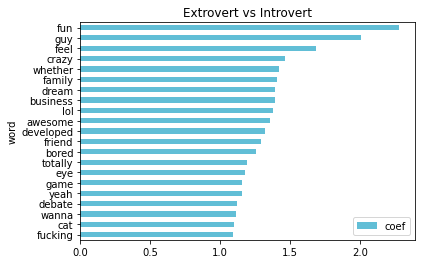

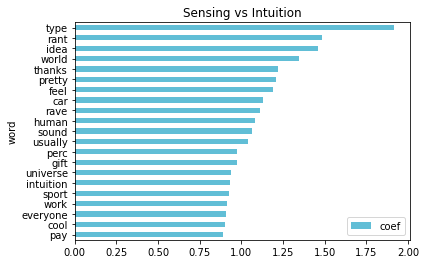

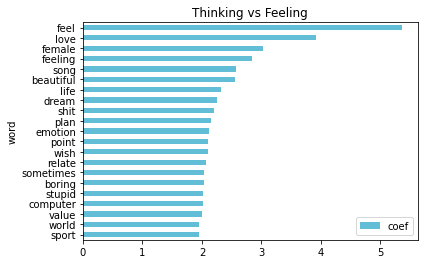

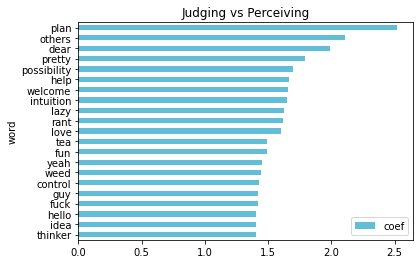

In [ ]:
for col in y_train.columns:
    
    print(f"\n{mbti_type[col]}")

    target = y_train[col]

    tfidf_logistic_regression = imb_make_pipeline(preprocesser_tf, RandomUnderSampler(), LogisticRegression())
    
    tfidf_logistic_regression.fit(X_train, target)
    
    # Choosing Important features based on coefficients
    coef = tfidf_logistic_regression[-1].coef_[0]  
    word = tfidf_logistic_regression[0].named_transformers_["tfidf"].get_feature_names()
    word_list = list(zip(word, coef))         
    result = pd.DataFrame(word_list, columns=["word", "coef"]).set_index("word")    
    result = result.reindex(result.coef.abs().sort_values(ascending=False).index)[0:21]
    print(result)
    
    # plotting important features
    result["coef"] = result["coef"].apply(lambda x: abs(x))
    result.sort_values("coef", inplace=True)
    result.plot(kind="barh", color="#61BED6", title=mbti_type[col])
  
    # saving the model
    dump(tfidf_logistic_regression, f"/content/drive/MyDrive/personality_data/{col}.joblib")

# Section 3: Testing Model

In [ ]:
def combine_classes(y_pred1, y_pred2, y_pred3, y_pred4):

    combined = []
    for i in range(len(y_pred1)):
        combined.append(str(y_pred1[i]) + str(y_pred2[i]) + str(y_pred3[i]) + str(y_pred4[i]))

    type_list = [
    {"0": "I", "1": "E"},
    {"0": "N", "1": "S"},
    {"0": "F", "1": "T"},
    {"0": "P", "1": "J"},
    ]
    
    result = []
    for num in combined:
        s = ""
        for i in range(len(num)):
            s += type_list[i][num[i]]
        result.append(s)

    return result

def predict(X, y):

    # loading the 4 models
    EorI_model = load("/content/drive/MyDrive/personality_data/Extroversion.joblib")
    SorN_model = load("/content/drive/MyDrive/personality_data/Sensing.joblib")
    TorF_model = load("/content/drive/MyDrive/personality_data/Thinking.joblib")
    JorP_model = load("/content/drive/MyDrive/personality_data/Judging.joblib")
    
    # predicting
    EorI_pred = EorI_model.predict(X)
    print("Extrovert vs Introvert Accuracy: ", accuracy_score(y["Extroversion"], EorI_pred),)

    SorN_pred = SorN_model.predict(X)
    print("\nSensing vs Intuition Accuracy: ", accuracy_score(y["Sensing"], SorN_pred))

    TorF_pred = TorF_model.predict(X)
    print("\nThinking vs Feeling Accuracy: ", accuracy_score(y["Thinking"], TorF_pred))
    
    JorP_pred = JorP_model.predict(X)
    print("\nJudging vs Perceiving Accuracy: ", accuracy_score(y["Judging"], JorP_pred))

    # combining the predictions from the 4 models
    result = combine_classes(EorI_pred, SorN_pred, TorF_pred, JorP_pred)

    return result

In [ ]:
predictions = predict(X_test, y_test)

Extrovert vs Introvert Accuracy:  0.6889400921658986

Sensing vs Intuition Accuracy:  0.6866359447004609

Thinking vs Feeling Accuracy:  0.782258064516129

Judging vs Perceiving Accuracy:  0.618663594470046


In [ ]:
df_test = X_test[['clean_posts']]
df_test = pd.concat([df_test, y_test], axis=1)
df_test["result"] = predictions
df_test

,clean_posts,Extroversion,Sensing,Thinking,Judging,result
6044,key lime yogurt read said one person get d...,0,0,1,1,ISFJ
2035,mostly directed suppose wanted see everyone ...,0,0,1,0,INTP
413,hey wondering experience public speaking hu...,0,0,0,1,INFJ
5100,damn long time anyway find perfect gif u...,1,0,1,0,ENTP
391,going die afterlife alive thing matter saw t...,0,1,0,0,ESTP
...,...,...,...,...,...,...
2291,imaginarium doctor parnassus trip without a...,0,0,0,0,INTP
1531,wondering city better need met regardless cu...,0,0,0,1,INFJ
7409,totally record never trouble getting date...,1,0,1,0,ESFP
3542,personally consider studying mean reviewing m...,0,0,0,0,INFP


# Section 4: Final model (For Web App)

In [ ]:
class PersonalityPrediction():

    def __init(self):
        pass

    def unique_words(self, s):
        unique = set(s.split(" "))
        return len(unique)

    def emojis(self, post):
        emoji_count = len(re.findall(r'[\U0001f600-\U0001f650]', post))
        return emoji_count

    def colons(self, post):
        colon_count = 0
        words = post.split()
        for e in words:
            if "http" not in e:
                colon_count += e.count(":")
        return colon_count

    def lemmatize(self, s):
        lemmatizer = WordNetLemmatizer()
        new_s = ""
        for word in s.split(" "):
            lemmatizer.lemmatize(word)
            if word not in stopwords.words("english"):
                new_s += word + " "
        return new_s[:-1]

    def clean(self, s):
        mbti = ["INFP","INFJ","INTP","INTJ","ENTP","ENFP","ISTP","ISFP","ENTJ","ISTJ","ENFJ","ISFJ","ESTP","ESFP","ESFJ","ESTJ",]
        # remove urls
        s = re.sub(re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+).*"), "", s)
        # remove emails
        s = re.sub(re.compile(r"\S+@\S+"), "", s)
        # remove punctuation
        s = re.sub(re.compile(r"[^a-z\s]"), "", s)
        # Make everything lowercase
        s = s.lower()
        # remove all personality types
        for type_word in mbti:
            s = s.replace(type_word.lower(), "")
        
        return s


    def prep_counts(self, s):
        clean_s = self.clean(s)
        d = {
            "clean_posts": self.lemmatize(clean_s),
            "link_count": s.count("http"),
            "youtube": s.count("youtube") + s.count("youtu.be"),
            "img_count": len(re.findall(r"(\.jpg)|(\.jpeg)|(\.gif)|(\.png)", s)),
            "upper": len([x for x in s.split() if x.isupper()]),
            "char_count": len(s),
            "word_count": clean_s.count(" ") + 1,
            "qm": s.count("?"),
            "em": s.count("!"),
            "colons": self.colons(s),
            "emojis": self.emojis(s),
            "unique_words": self.unique_words(clean_s),
            "ellipses": len(re.findall(r"\.\.\.\ ", s)),
        }
        return clean_s, d


    def prep_sentiment(self, s):
        analyzer = SentimentIntensityAnalyzer()
        score = analyzer.polarity_scores(s)
        d = {
            "compound_sentiment": score["compound"],
            "pos_sentiment": score["pos"],
            "neg_sentiment": score["neg"],
            "neu_sentiment": score["neu"],
        }
        return d


    def tag_pos(self, s):
        tagged_words = nltk.pos_tag(word_tokenize(s))
        tags_dict = {
            "ADJ_avg": ["JJ", "JJR", "JJS"],
            "ADP_avg": ["EX", "TO"],
            "ADV_avg": ["RB", "RBR", "RBS", "WRB"],
            "CONJ_avg": ["CC", "IN"],
            "DET_avg": ["DT", "PDT", "WDT"],
            "NOUN_avg": ["NN", "NNS", "NNP", "NNPS"],
            "NUM_avg": ["CD"],
            "PRT_avg": ["RP"],
            "PRON_avg": ["PRP", "PRP$", "WP", "WP$"],
            "VERB_avg": ["MD", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"],
            ".": ["#", "$", "''", "(", ")", ",", ".", ":"],
            "X": ["FW", "LS", "UH"],
        }
        d = dict.fromkeys(tags_dict, 0)
        for tup in tagged_words:
            tag = tup[1]
            for key, val in tags_dict.items():
                if tag in val:
                    tag = key
            d[tag] += 1
        return d


    def prep_data(self, s):
        clean_s, d = self.prep_counts(s)
        d.update(self.prep_sentiment(self.lemmatize(clean_s)))
        d.update(self.tag_pos(clean_s))
        features = [
            "clean_posts",
            "compound_sentiment",
            "ADJ_avg",
            "ADP_avg",
            "ADV_avg",
            "CONJ_avg",
            "DET_avg",
            "NOUN_avg",
            "NUM_avg",
            "PRT_avg",
            "PRON_avg",
            "VERB_avg",
            "qm",
            "em",
            "colons",
            "emojis",
            "word_count",
            "unique_words",
            "upper",
            "link_count",
            "ellipses",
            "img_count",
        ]

        return pd.DataFrame([d])[features]

    def combine_classes(self, y_pred1, y_pred2, y_pred3, y_pred4):

        combined = []
        for i in range(len(y_pred1)):
            combined.append(str(y_pred1[i]) + str(y_pred2[i]) + str(y_pred3[i]) + str(y_pred4[i]))

        type_list = [
        {"0": "I", "1": "E"},
        {"0": "N", "1": "S"},
        {"0": "F", "1": "T"},
        {"0": "P", "1": "J"},
        ]
        
        result = []
        for num in combined:
            s = ""
            for i in range(len(num)):
                s += type_list[i][num[i]]
            result.append(s)

        return result

    def predict(self, s):

        X = self.prep_data(s)

        # loading the 4 models
        EorI_model = load("/content/drive/MyDrive/personality_data/Extroversion.joblib")
        SorN_model = load("/content/drive/MyDrive/personality_data/Sensing.joblib")
        TorF_model = load("/content/drive/MyDrive/personality_data/Thinking.joblib")
        JorP_model = load("/content/drive/MyDrive/personality_data/Judging.joblib")

        # predicting
        EorI_pred = EorI_model.predict(X)
        print("Introvert vs Extrovert predictions:", EorI_pred)

        SorN_pred = SorN_model.predict(X)
        print("Sensing vs Intuition predictions:", SorN_pred)

        TorF_pred = TorF_model.predict(X)
        print("Thinking or Feeling predictions:", TorF_pred)

        JorP_pred = JorP_model.predict(X)
        print("Judging or Perceiving predictions:", JorP_pred)

        # combining the predictions from the 4 models
        result = self.combine_classes(EorI_pred, SorN_pred, TorF_pred, JorP_pred)

        return result[0]

In [ ]:
if __name__ == "__main__":
    t = time.time()
    person = PersonalityPrediction()
    string = "Wow, only three weeks to 2022! What will 2032 will be like? Seems so futuristic! Will we be on Mars? ||| thinking of quitting my jobs & becoming an influencer full-time wdyt ||| Laws are on one side, poets on the other ||| Let’s set an age limit after which you can’t run for political office, perhaps a number just below 70 … :)"
    print(person.predict(string))
    print(f"Time: {(time.time() - t):.2f} seconds")

Introvert vs Extrovert predictions: [0]
Sensing vs Intuition predictions: [1]
Thinking or Feeling predictions: [1]
Judging or Perceiving predictions: [1]
ISTJ
Time: 1.31 seconds
